In [1]:
# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

import pickle
def load_data(in_dir):
    f = open(in_dir,'rb')
    train_data,train_label,valid_data,valid_label = pickle.load(f)
    return train_data,train_label,valid_data,valid_label

# data_path = 'adress_512.pkl'
data_path = 'adress_pssat.pkl'
checkpoint = 'checkpoint/'

train_data,train_label,valid_data,valid_label = load_data(data_path)

# converting training images into torch format
train_x = train_data
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_label
train_y = train_y.reshape(train_y.shape[0]).astype(float);
train_y = torch.from_numpy(train_y)


# shape of training data
# train_x.shape, train_y.shape
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

# tensor_x = torch.Tensor(my_x) # transform to torch tensor
# tensor_y = torch.Tensor(my_y)

CTX = torch.device('cuda')

train_dataset = TensorDataset(train_x.to(CTX),train_y.to(CTX)) # create your datset

 # create your dataloader


In [2]:
# converting training images into torch format
val_x = valid_data
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = valid_label
val_y = val_y.reshape(val_y.shape[0]).astype(float);
val_y = torch.from_numpy(val_y)
# shape of training data

val_dataset = TensorDataset(val_x,val_y) # create your datset

In [3]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 64
# val_size = 297
# train_size = train_x.size(0) - val_size 

# train_data,val_data = random_split(dataset,[train_size,val_size])
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 2379
#Length of Validation Data : 297

#load the train and validation into batches.
train_dl = DataLoader(train_dataset,batch_size, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers = 0)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import recall_score as recall
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out, _softmax= self(images.to(CTX))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out, _softmax = self(images.to(CTX))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(torch.int64).cuda())   # Calculate loss
        acc = accuracy(_softmax, labels.to(torch.int64).cuda())           # Calculate accuracy
        
        valid_conf = confusion(np.argmax(_softmax.cpu(),1),labels.cpu())
#         valid_conf = 8008
#         print(np.argmax(out.cpu(),1))
#         print(labels.cpu())
        print ('Valid Confusion Matrix:["cc","cd"]')
        print(valid_conf)
        print ('Recall')
        print(recall(np.argmax(_softmax.cpu(),1),labels.cpu(),average='macro'))
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.8f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
#         print (result['valid_conf'])

In [28]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

# importing the libraries
import numpy as np

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
#         print(x.shape())
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class SAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(SAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.SpatialGate = SpatialGate()
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        M_c = self.ChannelGate(x)
        M_s = self.SpatialGate(x)
        
        M_f = self.sigmoid(M_c + M_s)
        
        
        return x + x*M_f
    
class self_Att_Net(ImageClassificationBase):   
    def __init__(self):
        super(self_Att_Net, self).__init__()
        #The LW_CNN module utilizes three convolutions (C), two max-pooling
        # (MP), one average-pooling (AP), and one batch normalization
        # (BN) layer.
        self.LW_CNN = Sequential(
            # Defining a 2D convolution layer
#             Conv2d(300, 256, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(256),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=2, stride=2),
#             # Defining another 2D convolution layer
#             Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
#             BatchNorm2d(128),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=1, stride=1),
            
              #C1, we used 120 number of kernels with size (11
              # × 11) using (4 × 4) stride setting without padding to extract
              # initially hidden patterns from input data. 
              Conv2d(3, 120, kernel_size=(11,11), stride=(4,4), padding=4),
              MaxPool2d(kernel_size=(3,3), stride=None),
              Conv2d(120, 256, kernel_size=(5,5), stride=(1,1), padding='same'),
              MaxPool2d(kernel_size=(3,3)),
              Conv2d(256, 384, kernel_size=(3,3), padding='same'),
#               MaxPool2d(kernel_size=1, stride=0),
#               Conv2d(128, 1, kernel_size=(3,3), stride=(1,1), padding='same'),
              torch.nn.AvgPool2d(kernel_size=(1,1)),
              BatchNorm2d(384),
              ReLU(inplace=True),
        )

        self.linear_layers = Sequential(
            Linear(384 * 8 * 1, 256),
            Linear(256, 64),
            Linear(64, 2),
        )

        self.attention = SAM(gate_channels=384)
        
        self.softmax_out = nn.Softmax(dim=1)
    # Defining the forward pass    
    def forward(self, x):
#         x = x.view(-1, x.size(3),x.size(2),x.size(1))
#         print(x.size)
        x = self.LW_CNN(x)
        x = self.attention(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        output_softmax = self.softmax_out(x)
        
        return x,output_softmax

In [29]:
# defining the model
model = self_Att_Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function

criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

self_Att_Net(
  (LW_CNN): Sequential(
    (0): Conv2d(3, 120, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(120, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): AvgPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0)
    (6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (attention): SAM(
    (ChannelGate): ChannelGate(
      (mlp): Sequential(
        (0): Flatten()
        (1): Linear(in_features=384, out_f

In [30]:
# !pip install torch-summary = '1.4.5'
from torchsummary import summary
summary(model, (3, 300, 40))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 384, 8, 1]           --
|    └─Conv2d: 2-1                       [-1, 120, 75, 10]         43,680
|    └─MaxPool2d: 2-2                    [-1, 120, 25, 3]          --
|    └─Conv2d: 2-3                       [-1, 256, 25, 3]          768,256
|    └─MaxPool2d: 2-4                    [-1, 256, 8, 1]           --
|    └─Conv2d: 2-5                       [-1, 384, 8, 1]           885,120
|    └─AvgPool2d: 2-6                    [-1, 384, 8, 1]           --
|    └─BatchNorm2d: 2-7                  [-1, 384, 8, 1]           768
|    └─ReLU: 2-8                         [-1, 384, 8, 1]           --
├─SAM: 1-2                               [-1, 384, 8, 1]           --
|    └─ChannelGate: 2-9                  [-1, 384, 8, 1]           --
|    |    └─Sequential: 3-1              [-1, 384]                 18,840
|    |    └─Sequential: 3-2              [-1, 384]                

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 384, 8, 1]           --
|    └─Conv2d: 2-1                       [-1, 120, 75, 10]         43,680
|    └─MaxPool2d: 2-2                    [-1, 120, 25, 3]          --
|    └─Conv2d: 2-3                       [-1, 256, 25, 3]          768,256
|    └─MaxPool2d: 2-4                    [-1, 256, 8, 1]           --
|    └─Conv2d: 2-5                       [-1, 384, 8, 1]           885,120
|    └─AvgPool2d: 2-6                    [-1, 384, 8, 1]           --
|    └─BatchNorm2d: 2-7                  [-1, 384, 8, 1]           768
|    └─ReLU: 2-8                         [-1, 384, 8, 1]           --
├─SAM: 1-2                               [-1, 384, 8, 1]           --
|    └─ChannelGate: 2-9                  [-1, 384, 8, 1]           --
|    |    └─Sequential: 3-1              [-1, 384]                 18,840
|    |    └─Sequential: 3-2              [-1, 384]                

In [31]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [33]:
# get training set size to calculate # iterations and minibatch indices
train_size = train_x.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model.to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []
best_val_acc = 0
best_epoch = 0
valid_acc = 0
# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):
    
    best_val_acc = 0
    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
           
        if valid_acc > best_val_acc:
            best_epoch = epoch
            best_val_acc = valid_acc
            print("Best one is",epoch,best_val_acc)
             # Save checkpoint of the model
            checkpoint_filename = 'checkpoint/SAM-{:03d}.pkl'.format(epoch)
            save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

cuda selected
Number of trainable params:  2520030


In [35]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 500

# train it!
train(optimizer, model, num_epochs, train_x, train_y, val_x, val_y)

C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/1478199906.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, device=device).float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/1478199906.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)


Epoch 0: iteration 74/75Best one is 0 tensor(69.5312, device='cuda:0')

Epoch 0 --- loss:0.020, Epoch accuracy:98.43%, Validation loss:1.083, Validation accuracy:69.53%
Epoch 1: iteration 7/75

C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/1478199906.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_valid_tensor = torch.tensor(X_valid,device=device).float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/1478199906.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)


Epoch 1: iteration 74/75Best one is 1 tensor(70.3125, device='cuda:0')

Epoch 1 --- loss:0.020, Epoch accuracy:98.18%, Validation loss:1.055, Validation accuracy:70.31%
Epoch 2: iteration 74/75
Epoch 2 --- loss:0.020, Epoch accuracy:98.34%, Validation loss:1.052, Validation accuracy:69.53%
Epoch 3: iteration 74/75Best one is 3 tensor(71.8750, device='cuda:0')

Epoch 3 --- loss:0.019, Epoch accuracy:98.34%, Validation loss:1.122, Validation accuracy:71.88%
Epoch 4: iteration 74/75
Epoch 4 --- loss:0.019, Epoch accuracy:98.22%, Validation loss:1.141, Validation accuracy:71.88%
Epoch 5: iteration 74/75
Epoch 5 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.165, Validation accuracy:69.53%
Epoch 6: iteration 74/75
Epoch 6 --- loss:0.020, Epoch accuracy:98.22%, Validation loss:1.114, Validation accuracy:71.88%
Epoch 7: iteration 74/75
Epoch 7 --- loss:0.019, Epoch accuracy:98.38%, Validation loss:1.119, Validation accuracy:69.53%
Epoch 8: iteration 74/75
Epoch 8 --- loss:0.021, Epo

Epoch 66: iteration 74/75
Epoch 66 --- loss:0.019, Epoch accuracy:98.43%, Validation loss:1.091, Validation accuracy:70.31%
Epoch 67: iteration 74/75
Epoch 67 --- loss:0.018, Epoch accuracy:98.26%, Validation loss:1.120, Validation accuracy:71.88%
Epoch 68: iteration 74/75
Epoch 68 --- loss:0.019, Epoch accuracy:98.18%, Validation loss:1.095, Validation accuracy:68.75%
Epoch 69: iteration 74/75
Epoch 69 --- loss:0.021, Epoch accuracy:98.22%, Validation loss:1.080, Validation accuracy:68.75%
Epoch 70: iteration 74/75
Epoch 70 --- loss:0.019, Epoch accuracy:98.30%, Validation loss:1.093, Validation accuracy:68.75%
Epoch 71: iteration 74/75
Epoch 71 --- loss:0.019, Epoch accuracy:98.43%, Validation loss:1.114, Validation accuracy:71.09%
Epoch 72: iteration 74/75
Epoch 72 --- loss:0.018, Epoch accuracy:98.30%, Validation loss:1.133, Validation accuracy:71.88%
Epoch 73: iteration 74/75
Epoch 73 --- loss:0.250, Epoch accuracy:89.02%, Validation loss:1.021, Validation accuracy:71.09%
Epoch 74

Epoch 131: iteration 74/75
Epoch 131 --- loss:0.020, Epoch accuracy:98.34%, Validation loss:1.188, Validation accuracy:70.31%
Epoch 132: iteration 74/75
Epoch 132 --- loss:0.018, Epoch accuracy:98.26%, Validation loss:1.221, Validation accuracy:68.75%
Epoch 133: iteration 74/75
Epoch 133 --- loss:0.020, Epoch accuracy:98.26%, Validation loss:1.124, Validation accuracy:67.97%
Epoch 134: iteration 74/75
Epoch 134 --- loss:0.019, Epoch accuracy:98.30%, Validation loss:1.151, Validation accuracy:67.97%
Epoch 135: iteration 74/75
Epoch 135 --- loss:0.019, Epoch accuracy:98.43%, Validation loss:1.215, Validation accuracy:68.75%
Epoch 136: iteration 74/75
Epoch 136 --- loss:0.018, Epoch accuracy:98.34%, Validation loss:1.267, Validation accuracy:68.75%
Epoch 137: iteration 74/75
Epoch 137 --- loss:0.018, Epoch accuracy:98.43%, Validation loss:1.170, Validation accuracy:67.19%
Epoch 138: iteration 74/75
Epoch 138 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.231, Validation accuracy

Epoch 196: iteration 74/75
Epoch 196 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.176, Validation accuracy:67.97%
Epoch 197: iteration 74/75
Epoch 197 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.175, Validation accuracy:67.19%
Epoch 198: iteration 74/75
Epoch 198 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.205, Validation accuracy:67.97%
Epoch 199: iteration 74/75
Epoch 199 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.232, Validation accuracy:67.19%
Epoch 200: iteration 74/75
Epoch 200 --- loss:0.018, Epoch accuracy:98.43%, Validation loss:1.172, Validation accuracy:66.41%
Epoch 201: iteration 74/75
Epoch 201 --- loss:0.018, Epoch accuracy:98.43%, Validation loss:1.199, Validation accuracy:66.41%
Epoch 202: iteration 74/75
Epoch 202 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.212, Validation accuracy:67.97%
Epoch 203: iteration 74/75
Epoch 203 --- loss:0.018, Epoch accuracy:98.30%, Validation loss:1.160, Validation accuracy

Epoch 261: iteration 74/75
Epoch 261 --- loss:0.035, Epoch accuracy:97.93%, Validation loss:1.478, Validation accuracy:59.38%
Epoch 262: iteration 74/75
Epoch 262 --- loss:0.046, Epoch accuracy:97.93%, Validation loss:1.497, Validation accuracy:65.62%
Epoch 263: iteration 74/75
Epoch 263 --- loss:0.034, Epoch accuracy:98.01%, Validation loss:1.288, Validation accuracy:65.62%
Epoch 264: iteration 74/75
Epoch 264 --- loss:0.028, Epoch accuracy:98.09%, Validation loss:1.403, Validation accuracy:66.41%
Epoch 265: iteration 74/75
Epoch 265 --- loss:0.022, Epoch accuracy:98.34%, Validation loss:1.396, Validation accuracy:67.97%
Epoch 266: iteration 74/75
Epoch 266 --- loss:0.019, Epoch accuracy:98.26%, Validation loss:1.537, Validation accuracy:66.41%
Epoch 267: iteration 74/75
Epoch 267 --- loss:0.020, Epoch accuracy:98.30%, Validation loss:1.478, Validation accuracy:65.62%
Epoch 268: iteration 74/75
Epoch 268 --- loss:0.019, Epoch accuracy:98.22%, Validation loss:1.486, Validation accuracy

Epoch 326: iteration 74/75
Epoch 326 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.334, Validation accuracy:67.19%
Epoch 327: iteration 74/75
Epoch 327 --- loss:0.017, Epoch accuracy:98.47%, Validation loss:1.340, Validation accuracy:70.31%
Epoch 328: iteration 74/75
Epoch 328 --- loss:0.017, Epoch accuracy:98.47%, Validation loss:1.363, Validation accuracy:70.31%
Epoch 329: iteration 74/75
Epoch 329 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.208, Validation accuracy:68.75%
Epoch 330: iteration 74/75
Epoch 330 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.275, Validation accuracy:67.97%
Epoch 331: iteration 74/75
Epoch 331 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.278, Validation accuracy:70.31%
Epoch 332: iteration 74/75
Epoch 332 --- loss:0.020, Epoch accuracy:98.18%, Validation loss:1.198, Validation accuracy:66.41%
Epoch 333: iteration 74/75
Epoch 333 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.285, Validation accuracy

Epoch 391: iteration 74/75
Epoch 391 --- loss:0.019, Epoch accuracy:98.47%, Validation loss:1.218, Validation accuracy:66.41%
Epoch 392: iteration 74/75
Epoch 392 --- loss:0.018, Epoch accuracy:98.34%, Validation loss:1.273, Validation accuracy:64.84%
Epoch 393: iteration 74/75
Epoch 393 --- loss:0.019, Epoch accuracy:98.43%, Validation loss:1.125, Validation accuracy:65.62%
Epoch 394: iteration 74/75
Epoch 394 --- loss:0.019, Epoch accuracy:98.34%, Validation loss:1.296, Validation accuracy:65.62%
Epoch 395: iteration 74/75
Epoch 395 --- loss:0.018, Epoch accuracy:98.43%, Validation loss:1.262, Validation accuracy:67.19%
Epoch 396: iteration 74/75
Epoch 396 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.243, Validation accuracy:68.75%
Epoch 397: iteration 74/75
Epoch 397 --- loss:0.017, Epoch accuracy:98.47%, Validation loss:1.311, Validation accuracy:65.62%
Epoch 398: iteration 74/75
Epoch 398 --- loss:0.017, Epoch accuracy:98.47%, Validation loss:1.315, Validation accuracy

Epoch 456: iteration 74/75
Epoch 456 --- loss:0.018, Epoch accuracy:98.47%, Validation loss:1.499, Validation accuracy:65.62%
Epoch 457: iteration 74/75
Epoch 457 --- loss:0.023, Epoch accuracy:98.34%, Validation loss:1.319, Validation accuracy:64.84%
Epoch 458: iteration 74/75
Epoch 458 --- loss:0.020, Epoch accuracy:98.34%, Validation loss:1.323, Validation accuracy:67.19%
Epoch 459: iteration 74/75
Epoch 459 --- loss:0.018, Epoch accuracy:98.38%, Validation loss:1.351, Validation accuracy:67.97%
Epoch 460: iteration 74/75
Epoch 460 --- loss:0.019, Epoch accuracy:98.22%, Validation loss:1.320, Validation accuracy:62.50%
Epoch 461: iteration 74/75
Epoch 461 --- loss:0.017, Epoch accuracy:98.55%, Validation loss:1.393, Validation accuracy:64.84%
Epoch 462: iteration 74/75
Epoch 462 --- loss:0.019, Epoch accuracy:98.38%, Validation loss:1.408, Validation accuracy:64.84%
Epoch 463: iteration 74/75
Epoch 463 --- loss:0.018, Epoch accuracy:98.43%, Validation loss:1.411, Validation accuracy

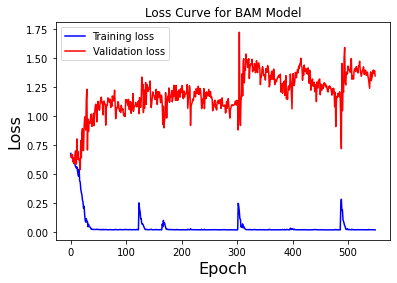

In [36]:
import matplotlib.pyplot as plt

plt.title('Loss Curve for BAM Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [40]:
import os
# pick load folder  
load_folder = 'checkpoint'  

# pick the epoch to load
epoch = '118'
model_name = f'BAM-{epoch}.pkl'

# make full load path
load_path = os.path.join(load_folder, model_name)

## instantiate empty model and populate with params from binary 
model = self_Att_Net()
load_checkpoint(optimizer, model, load_path)

print(f'Loaded model from {load_path}')

Loaded model from checkpoint\BAM-118.pkl


In [41]:
validate = make_validate_fnc(model,criterion)

X_val = val_x
y_val = val_y
# Convert 4D test feature set array to tensor and move to GPU
X_val_tensor = torch.tensor(X_val,device='cpu').float()
# Convert 4D test label set array to tensor and move to GPU
y_val_tensor = torch.tensor(y_val,dtype=torch.long,device='cpu')

# Get the model's performance metrics using the validation function we defined
_loss, _acc, predicted_emotions = validate(X_val_tensor,y_val_tensor)

print(f'Validation accuracy is {_acc:.2f}%')

Validation accuracy is 75.78%


C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/2725604674.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val,device='cpu').float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/2725604674.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val,dtype=torch.long,device='cpu')
C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


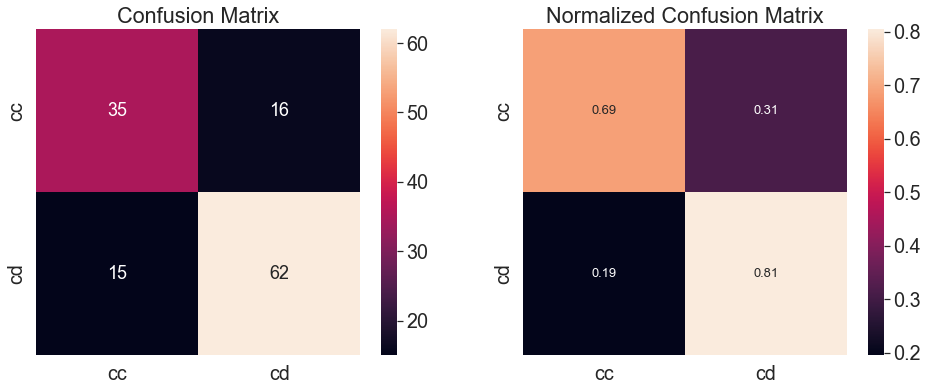

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions
# use labels from test set
emotions_groundtruth = y_val

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = ['cc', 'cd']

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

ToDo: Make X_Test and Y_Test, Confusion Matrix, 

In [43]:
data_path = 'adress_test_3_channles.pkl'

X_test,Y_test,speaker,segment = load_data(data_path)
# converting training images into torch format
X_test  = torch.from_numpy(X_test)

# converting the target into torch format

Y_test = Y_test.reshape(Y_test.shape[0]).astype(float);
y_test = torch.from_numpy(Y_test)

# reinitialize validation function with model from chosen checkpoint
validate = make_validate_fnc(model,criterion)

# Convert 4D test feature set array to tensor and move to GPU
X_test_tensor = torch.tensor(X_test,device='cpu').float()
# Convert 4D test label set array to tensor and move to GPU
y_test_tensor = torch.tensor(y_test,dtype=torch.long,device='cpu')

# Get the model's performance metrics using the validation function we defined
test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)

print(f'Test accuracy is {test_acc:.2f}%')

C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/738736624.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test,device='cpu').float()
C:\Users\Asus\AppData\Local\Temp/ipykernel_9364/738736624.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test,dtype=torch.long,device='cpu')


Test accuracy is 55.96%


C:\Users\Asus\anaconda3\envs\tf-btp\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


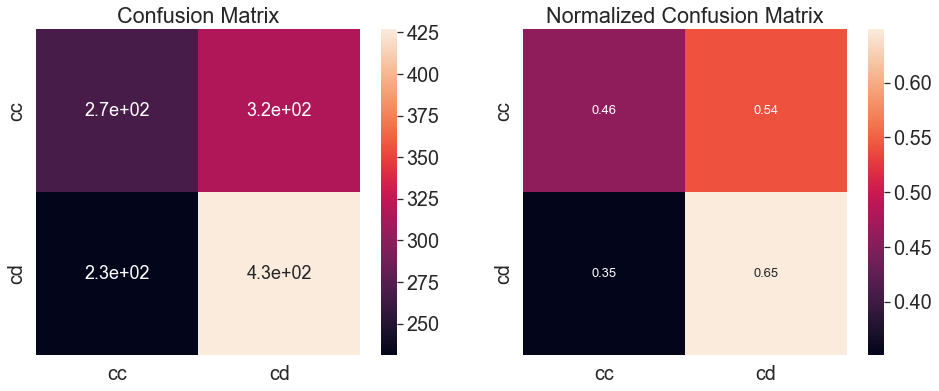

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
# because model tested on GPU, move prediction tensor to CPU then convert to array
predicted_emotions = predicted_emotions
# use labels from test set
emotions_groundtruth = y_test

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth, predicted_emotions)
conf_matrix_norm = confusion_matrix(emotions_groundtruth, predicted_emotions,normalize='true')

# set labels for matrix axes from emotions
emotion_names = ['cc', 'cd']

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

In [45]:
speaker_dict = {}
for spk,seg,emo, y in zip(speaker,segment,predicted_emotions,y_test):
    print(spk,seg,emo.cpu(), y.cpu())
    speaker_dict[spk] = y.item()

S160.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 6 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 10 tensor(0) tensor(0., dtype=torch.f

S193.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 10 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 11 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 12 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 13 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 14 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 15 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 16 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 17 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 18 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 19 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 20 tensor(0) tensor(0., dtype=torch.float64)
S193.wav 21 tensor(1) tensor(0., dtype=torch.float64)
S193.wav 22 tensor(1) tensor(0., dtype=torch.float64)
S195.wav 0 tensor(0) tensor(0., d

S168.wav 5 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 6 tensor(0) tensor(1., dtype=torch.float64)
S168.wav 7 tensor(0) tensor(1., dtype=torch.float64)
S168.wav 8 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 9 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 10 tensor(1) tensor(1., dtype=torch.float64)
S168.wav 11 tensor(0) tensor(1., dtype=torch.float64)
S168.wav 12 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 0 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 1 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 2 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 3 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 4 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 5 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 6 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 7 tensor(1) tensor(1., dtype=torch.float64)
S169.wav 8 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 9 tensor(0) tensor(1., dtype=torch.float64)
S169.wav 10 tensor(0) tensor(1., dtype=torc

S191.wav 9 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 10 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 11 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 12 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 13 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 14 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 15 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 16 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 17 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 18 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 19 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 20 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 21 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 22 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 23 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 24 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 25 tensor(0) tensor(1., dtype=torch.float64)
S191.wav 26 tensor(1) tensor(1., dtype=torch.float64)
S191.wav 27 tensor(0) tensor(

In [46]:
speaker_dict

{'S160.wav': 0.0,
 'S161.wav': 0.0,
 'S163.wav': 0.0,
 'S166.wav': 0.0,
 'S170.wav': 0.0,
 'S172.wav': 0.0,
 'S174.wav': 0.0,
 'S175.wav': 0.0,
 'S177.wav': 0.0,
 'S178.wav': 0.0,
 'S180.wav': 0.0,
 'S183.wav': 0.0,
 'S184.wav': 0.0,
 'S186.wav': 0.0,
 'S193.wav': 0.0,
 'S195.wav': 0.0,
 'S196.wav': 0.0,
 'S197.wav': 0.0,
 'S199.wav': 0.0,
 'S201.wav': 0.0,
 'S202.wav': 0.0,
 'S204.wav': 0.0,
 'S206.wav': 0.0,
 'S207.wav': 0.0,
 'S162.wav': 1.0,
 'S164.wav': 1.0,
 'S165.wav': 1.0,
 'S167.wav': 1.0,
 'S168.wav': 1.0,
 'S169.wav': 1.0,
 'S171.wav': 1.0,
 'S173.wav': 1.0,
 'S176.wav': 1.0,
 'S179.wav': 1.0,
 'S181.wav': 1.0,
 'S182.wav': 1.0,
 'S185.wav': 1.0,
 'S188.wav': 1.0,
 'S189.wav': 1.0,
 'S190.wav': 1.0,
 'S191.wav': 1.0,
 'S192.wav': 1.0,
 'S194.wav': 1.0,
 'S198.wav': 1.0,
 'S200.wav': 1.0,
 'S203.wav': 1.0,
 'S205.wav': 1.0}

In [47]:
output_dict = {}

for spk,seg,emo, y in zip(speaker,segment,predicted_emotions,y_test):
    print(spk,seg,emo.cpu(), y.cpu())
    output_dict[spk] = []

S160.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 6 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 10 tensor(0) tensor(0., dtype=torch.f

S180.wav 21 tensor(1) tensor(0., dtype=torch.float64)
S180.wav 22 tensor(1) tensor(0., dtype=torch.float64)
S180.wav 23 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 0 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 8 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 10 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 11 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 12 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 13 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 14 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 15 tensor(0) tensor(0., dtype

S199.wav 13 tensor(0) tensor(0., dtype=torch.float64)
S199.wav 14 tensor(1) tensor(0., dtype=torch.float64)
S199.wav 15 tensor(0) tensor(0., dtype=torch.float64)
S199.wav 16 tensor(1) tensor(0., dtype=torch.float64)
S199.wav 17 tensor(1) tensor(0., dtype=torch.float64)
S199.wav 18 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 0 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 1 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 2 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S201.wav 8 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 9 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 10 tensor(0) tensor(0., dtype=torch.float64)
S201.wav 11 tensor(1) tensor(0., dtype=torch.float64)
S201.wav 12 tensor(1) tensor(0., dtype

S167.wav 28 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 29 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 30 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 31 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 32 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 33 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 34 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 35 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 36 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 37 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 38 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 39 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 40 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 41 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 42 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 43 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 44 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 45 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 46 tensor(1) tensor

S188.wav 14 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 15 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 16 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 17 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 18 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 19 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 20 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 21 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 22 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 23 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 24 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 25 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 26 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 27 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 28 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 29 tensor(0) tensor(1., dtype=torch.float64)
S188.wav 30 tensor(1) tensor(1., dtype=torch.float64)
S188.wav 31 tensor(0) tensor(1., dtype=torch.float64)
S189.wav 0 tensor(1) tensor(

In [48]:
output_dict

{'S160.wav': [],
 'S161.wav': [],
 'S163.wav': [],
 'S166.wav': [],
 'S170.wav': [],
 'S172.wav': [],
 'S174.wav': [],
 'S175.wav': [],
 'S177.wav': [],
 'S178.wav': [],
 'S180.wav': [],
 'S183.wav': [],
 'S184.wav': [],
 'S186.wav': [],
 'S193.wav': [],
 'S195.wav': [],
 'S196.wav': [],
 'S197.wav': [],
 'S199.wav': [],
 'S201.wav': [],
 'S202.wav': [],
 'S204.wav': [],
 'S206.wav': [],
 'S207.wav': [],
 'S162.wav': [],
 'S164.wav': [],
 'S165.wav': [],
 'S167.wav': [],
 'S168.wav': [],
 'S169.wav': [],
 'S171.wav': [],
 'S173.wav': [],
 'S176.wav': [],
 'S179.wav': [],
 'S181.wav': [],
 'S182.wav': [],
 'S185.wav': [],
 'S188.wav': [],
 'S189.wav': [],
 'S190.wav': [],
 'S191.wav': [],
 'S192.wav': [],
 'S194.wav': [],
 'S198.wav': [],
 'S200.wav': [],
 'S203.wav': [],
 'S205.wav': []}

In [49]:
for spk,seg,emo, y in zip(speaker,segment,predicted_emotions,y_test):
    print(spk,seg,emo.cpu(), y.cpu())
    output_dict[spk].append(emo.item())

S160.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S160.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S160.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 2 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S161.wav 6 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 7 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S161.wav 10 tensor(0) tensor(0., dtype=torch.f

S183.wav 27 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 28 tensor(1) tensor(0., dtype=torch.float64)
S183.wav 29 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 30 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 31 tensor(0) tensor(0., dtype=torch.float64)
S183.wav 32 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 0 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 1 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 2 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 3 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 4 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 5 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 8 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 10 tensor(0) tensor(0., dtype=torch.float64)
S184.wav 11 tensor(1) tensor(0., dtype=torch.float64)
S184.wav 12 tensor(1) tensor(0., dtype

S201.wav 17 tensor(0) tensor(0., dtype=torch.float64)
S201.wav 18 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 0 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 1 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 2 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 3 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 4 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 5 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 6 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 7 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 8 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 9 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 10 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 11 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 12 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 13 tensor(1) tensor(0., dtype=torch.float64)
S202.wav 14 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 15 tensor(0) tensor(0., dtype=torch.float64)
S202.wav 16 tensor(0) tensor(0., dtype

S167.wav 43 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 44 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 45 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 46 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 47 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 48 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 49 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 50 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 51 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 52 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 53 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 54 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 55 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 56 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 57 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 58 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 59 tensor(0) tensor(1., dtype=torch.float64)
S167.wav 60 tensor(1) tensor(1., dtype=torch.float64)
S167.wav 61 tensor(1) tensor

S189.wav 3 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 4 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 5 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 6 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 7 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 8 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 9 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 10 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 11 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 12 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 13 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 14 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 15 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 16 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 17 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 18 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 19 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 20 tensor(1) tensor(1., dtype=torch.float64)
S189.wav 21 tensor(1) tensor(1., dt

In [50]:
output_dict

{'S160.wav': [0, 0, 0, 0, 1, 0, 1, 1],
 'S161.wav': [0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0],
 'S163.wav': [1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1],
 'S166.wav': [0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0],
 'S170.wav': [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
 'S172.wav': [0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0],
 'S174.wav': [1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  1],
 'S175.

In [51]:
sum([1,0,4])

5

In [52]:
results_dict = {}
for spk in output_dict:
    summition = sum(output_dict[spk])
    length = len(output_dict[spk])
    ad = 0
    if(summition/length<0.3):
        ad = 0.0
    else:
        ad = 1.0
    results_dict[spk] = ad
#     print(summition/length)

In [53]:
tp = 0
fp = 0
tn = 0
fn = 0
wrong_prediction = 0
for spk in output_dict:
   
    res = results_dict[spk]
    test = speaker_dict[spk]
    print(spk,res,test)
    if(res != test):
        wrong_prediction += 1
wrong_prediction

S160.wav 1.0 0.0
S161.wav 1.0 0.0
S163.wav 1.0 0.0
S166.wav 1.0 0.0
S170.wav 1.0 0.0
S172.wav 1.0 0.0
S174.wav 1.0 0.0
S175.wav 1.0 0.0
S177.wav 1.0 0.0
S178.wav 1.0 0.0
S180.wav 1.0 0.0
S183.wav 1.0 0.0
S184.wav 1.0 0.0
S186.wav 1.0 0.0
S193.wav 0.0 0.0
S195.wav 1.0 0.0
S196.wav 0.0 0.0
S197.wav 1.0 0.0
S199.wav 1.0 0.0
S201.wav 1.0 0.0
S202.wav 1.0 0.0
S204.wav 1.0 0.0
S206.wav 1.0 0.0
S207.wav 1.0 0.0
S162.wav 1.0 1.0
S164.wav 0.0 1.0
S165.wav 1.0 1.0
S167.wav 1.0 1.0
S168.wav 1.0 1.0
S169.wav 0.0 1.0
S171.wav 1.0 1.0
S173.wav 1.0 1.0
S176.wav 1.0 1.0
S179.wav 1.0 1.0
S181.wav 1.0 1.0
S182.wav 1.0 1.0
S185.wav 1.0 1.0
S188.wav 1.0 1.0
S189.wav 1.0 1.0
S190.wav 1.0 1.0
S191.wav 1.0 1.0
S192.wav 1.0 1.0
S194.wav 1.0 1.0
S198.wav 1.0 1.0
S200.wav 1.0 1.0
S203.wav 1.0 1.0
S205.wav 1.0 1.0


24

In [54]:
len(results_dict)

47

In [55]:
print(wrong_prediction/len(results_dict))

0.5106382978723404
